In [1]:
# https://forums.fast.ai/t/unet-binary-segmentation/29833/36
# https://walkwithfastai.com/Binary_Segmentation
# https://www.tensorflow.org/tutorials/images/segmentation

from fastai.vision.all import *
# %% [markdown]
# images
path = Path(".").absolute().parent / "data/train"
fnames = get_image_files(path/"images")
print('example file name:', fnames[0])
print('of', len(fnames), 'training examples')

example file name: D:\Dev\hedgehog_finder\data\train\images\1\1.png
of 301 training examples


## Define DataLoaders

In [2]:
from hedgiefinder.dataloading import get_msk

codes = ['Background', 'Hog', 'Outline']

hogvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_msk,
                   batch_tfms=aug_transforms(do_flip=False, max_rotate=2),
                   item_tfms=Resize(224, method='squish'))

dls = hogvid.dataloaders(path / "images", path=path, bs=10)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


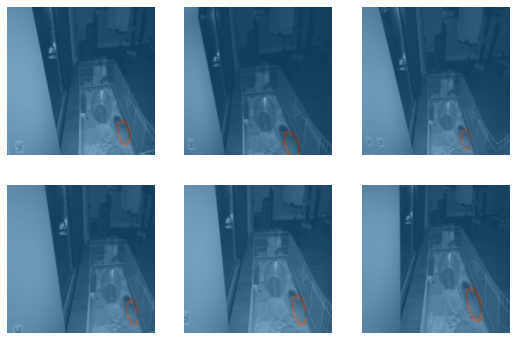

In [3]:
dls.show_batch(max_n=6, unique=True)

In [4]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([10, 3, 224, 224]), torch.Size([10, 224, 224]))

epoch,train_loss,valid_loss,foreground_acc,time
0,0.131406,0.037522,0.000000,00:31


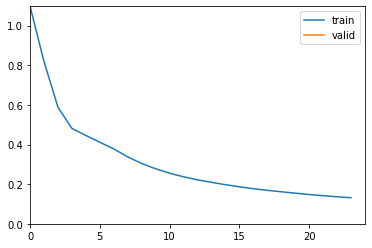

epoch,train_loss,valid_loss,foreground_acc,time
0,0.029626,0.059909,0.000000,00:28
1,0.024675,0.061991,0.000000,00:29
2,0.020319,0.068757,0.000000,00:28
3,0.017583,0.065722,0.010214,00:29
4,0.016230,0.030549,0.175937,00:29
5,0.014533,0.070438,0.052529,00:28
6,0.013145,0.041951,0.275829,00:29
7,0.012280,0.025955,0.338762,00:28
8,0.011094,0.031326,0.278340,00:28
9,0.010185,0.031130,0.305856,00:29


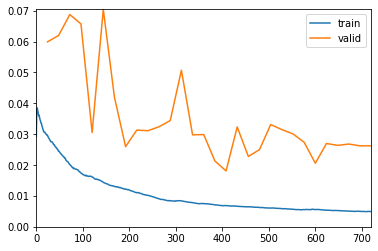

In [5]:
learn = unet_learner(dls, resnet34, cbs=ShowGraphCallback(), metrics=[foreground_acc])
learn.fine_tune(25)

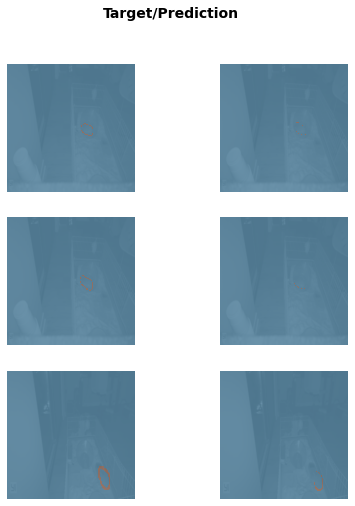

In [7]:
learn.show_results(max_n=3, figsize=(7,8))

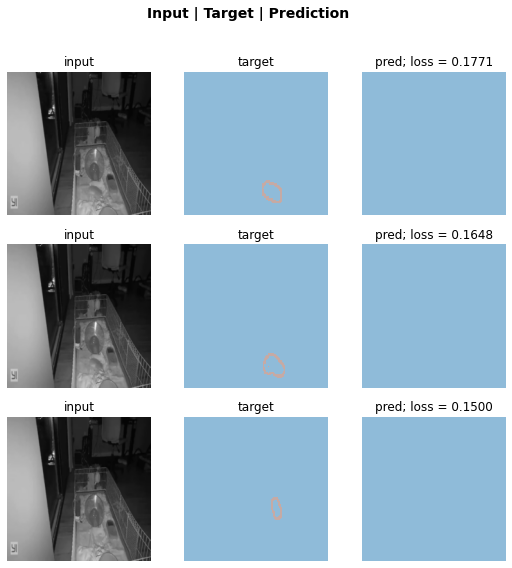

In [8]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

In [9]:
from datetime import datetime
model_path = path.parent.parent / 'hedgiefinder' / 'models'
model_name = model_path / datetime.now().strftime("%Y%m%d_%H%M.pkl")

model_dir = model_name.parent
model_dir.mkdir(exist_ok=True)

learn.export(model_name)
print(model_name)

D:\Dev\hedgehog_finder\hedgiefinder\models\20210304_1851.pkl


In [12]:
from hedgiefinder import HedgieFinder, alpha_mask

In [16]:
test_im = fnames[0]
originals, predictions = HedgieFinder(test_im).predict_image(test_im)
overlay = alpha_mask(originals_predictions)

Loading Video...


(array([[[128, 128, 128],
         [128, 128, 128],
         [126, 126, 126],
         ...,
         [ 38,  38,  38],
         [ 38,  38,  38],
         [ 38,  38,  38]],
 
        [[128, 128, 128],
         [126, 126, 126],
         [125, 125, 125],
         ...,
         [ 38,  38,  38],
         [ 38,  38,  38],
         [ 38,  38,  38]],
 
        [[126, 126, 126],
         [125, 125, 125],
         [125, 125, 125],
         ...,
         [ 38,  38,  38],
         [ 38,  38,  38],
         [ 38,  38,  38]],
 
        ...,
 
        [[179, 179, 179],
         [179, 179, 179],
         [178, 178, 178],
         ...,
         [100, 100, 100],
         [100, 100, 100],
         [ 98,  98,  98]],
 
        [[180, 180, 180],
         [180, 180, 180],
         [179, 179, 179],
         ...,
         [100, 100, 100],
         [100, 100, 100],
         [ 98,  98,  98]],
 
        [[180, 180, 180],
         [180, 180, 180],
         [179, 179, 179],
         ...,
         [100, 100, 100],
  

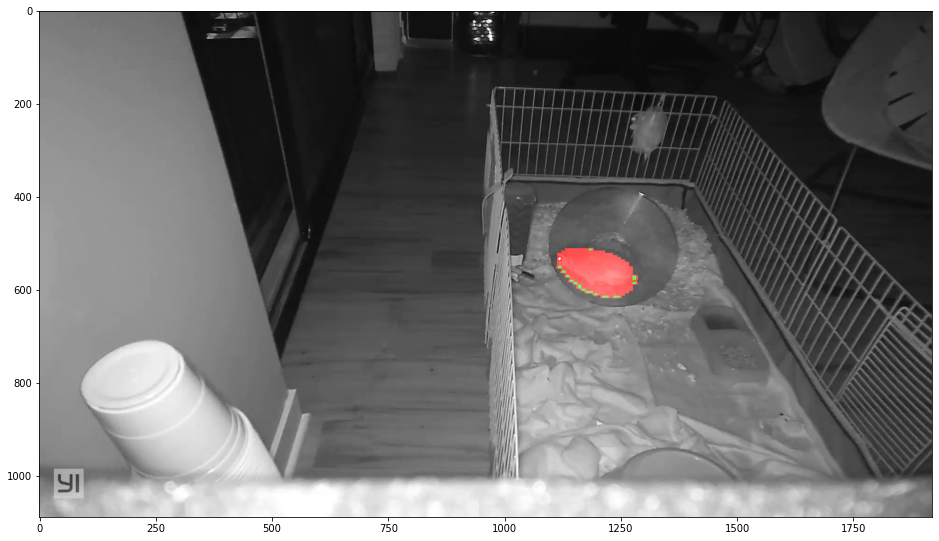

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
out = learn.predict(fnames[0])
# %%
def show_res(fn):
  im = np.array(PILImage.create(fn))
  out = learn.predict(fn)[1]
  mask = np.array(Image.fromarray(out.numpy().astype(np.uint8)).resize((1920,1088)))
  im[mask==1, 0] = 255
  im[mask==2, 1] = 255
  f, axs = plt.subplots(1,1, figsize=(16,16))
  axs.imshow(im)

show_res(fnames[25])